# Preparations

##  Modules Required

In [11]:
# !pip install numpy pandas geotext tweet-preprocessor nltk wordcloud plotly pycountry

## Mount Google Drive

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import required modules

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob
from geotext import GeoText
import nltk
import plotly.graph_objects as go
from wordcloud import WordCloud
import pycountry

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mukul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Configurations

In [15]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'facebook'
TARGET_NAME = TARGET
if IS_SAMPLE_ANALYSIS:
    TARGET_NAME += '_sample'
FIGURE_SIZE = (12,7)
# FOLDER_LOCATION = '/content/drive/My Drive/Projects/Twitter Data Sentiment Analysis/data/'
# FOLDER_LOCATION = '/content/drive/My Drive/DM/'
FOLDER_LOCATION = '../data/'
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Load Data

In [16]:
tweets = pd.read_csv(FOLDER_LOCATION + TARGET_NAME + '.csv', index_col=0, converters={i: str for i in range(0, 8)})

In [17]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,source_device,clean_text,country
339535,found a group on facebook of jeongmin shippers...,1584861413,hotgirlyoongi,1241624877703938050,1241624877703938050,Twitter for iPhone,found a group on facebook of jeongmin shippers...,NaN
339536,@myvivechurch is going live in 10mins via @fac...,1584861415,BrianMulondo,1241624884851150849,1241624884851150849,Twitter for iPhone,is going live in mins via and audacious2020,UG
339537,Brilliant idea!!! Saw this on facebook and i t...,1584861417,Teddyyybooiii,1241613999621279745,1241624893382250496,Twitter for Android,brilliant idea!!! saw this on facebook and i t...,NaN
339538,"daily routine :\r\n\r\n""opens twitter""\r\n""scr...",1584861420,maryangelinecdr,1240950387265302528,1241624906971955201,Twitter for Android,"daily routine ""opens twitter"" ""scrolls"" ""close...",PH
339539,"daily routine :\r\n\r\n""opens twitter""\r\n""scr...",1584861426,charmec_,1240950387265302528,1241624929570705408,Twitter for Android,"daily routine ""opens twitter"" ""scrolls"" ""close...",PH


# Feature Creation

## 'is_retweet' from 'tweet_source' and 'tweet_id'

In [18]:
def is_retweet(x):
    return x[0] != x[1]

In [19]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [20]:
tweets[['tweet_source','tweet_id','is_retweet']].tail()

,tweet_source,tweet_id,is_retweet
339535,1241624877703938050,1241624877703938050,False
339536,1241624884851150849,1241624884851150849,False
339537,1241613999621279745,1241624893382250496,True
339538,1240950387265302528,1241624906971955201,True
339539,1240950387265302528,1241624929570705408,True


## 'datetime' from 'timestamp'

In [21]:
def get_datetime(ts):
    return datetime.fromtimestamp(int(ts))

In [22]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

# Analysis

## Tweet distribution over time

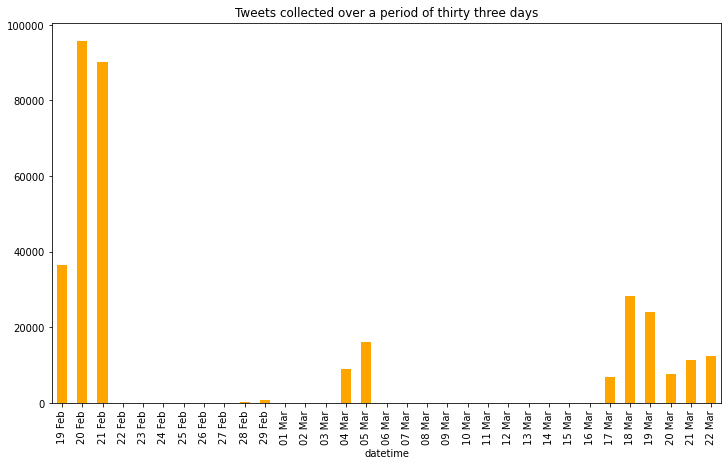

In [23]:
tweets_over_time = tweets[['datetime','timestamp']].groupby(pd.Grouper(key='datetime', freq='D')).size()
graph = tweets_over_time.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweets collected over a period of thirty three days')
graph.set_xticklabels(map(lambda x: x.strftime("%d %b"), tweets_over_time.index))
plt.show()

To see how peoples sentiment changes over time, data was collected over a period of 33 days in three batches. Each batch has data of roughly 60 to 120 hours.

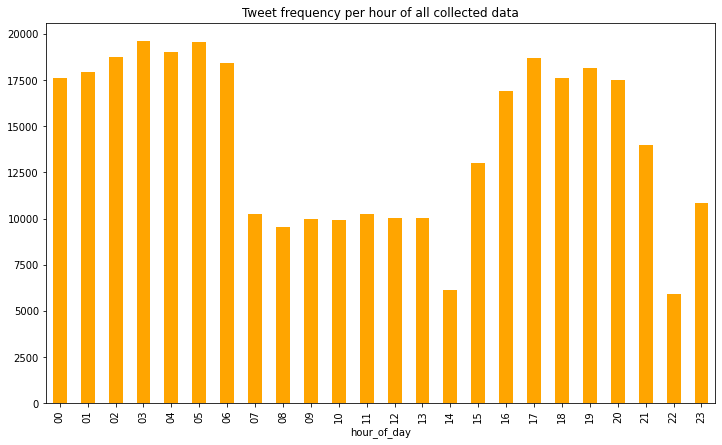

In [24]:
tweets['hour_of_day'] = tweets['datetime'].apply(lambda x: str(x)[11:13])
tweets[['hour_of_day','datetime']].groupby('hour_of_day').size().plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweet frequency per hour of all collected data')
plt.show()

Plotting number of tweets over 24 hours each day to understand when people tweet the most.

## Percentage of retweets in tweets

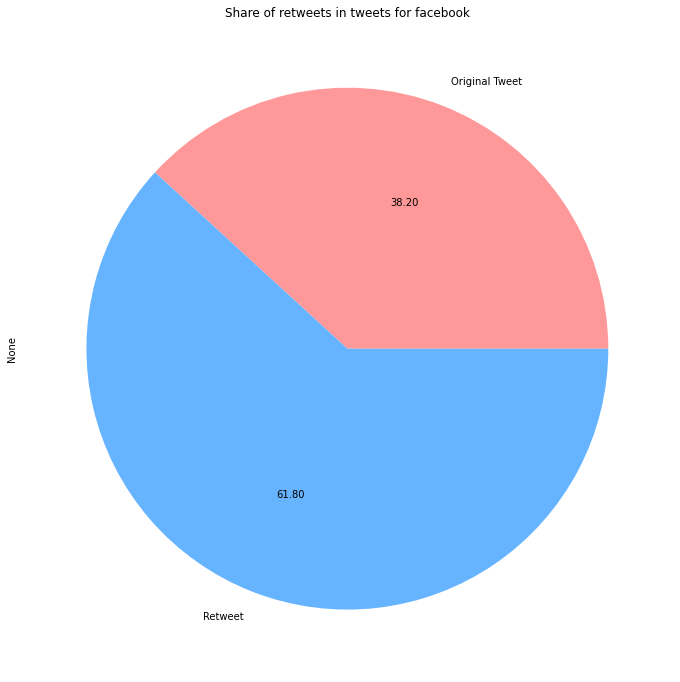

In [25]:
tweet_retweet_share = tweets[['is_retweet','user']].groupby('is_retweet').size()
tweet_retweet_share.index = ['Original Tweet', 'Retweet']
tweet_retweet_share.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Share of retweets in tweets for {TARGET}')
plt.show()

This chart shows that about 1/3rd of our tweets are retweets. People retweet something when they endorse it, thus asserting the same sentiment as original tweet more strongly in our data.

## Analysis of tweet text

### Most used words

In [26]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_clean_text.append(word)
all_clean_text = ' '.join(all_clean_text)

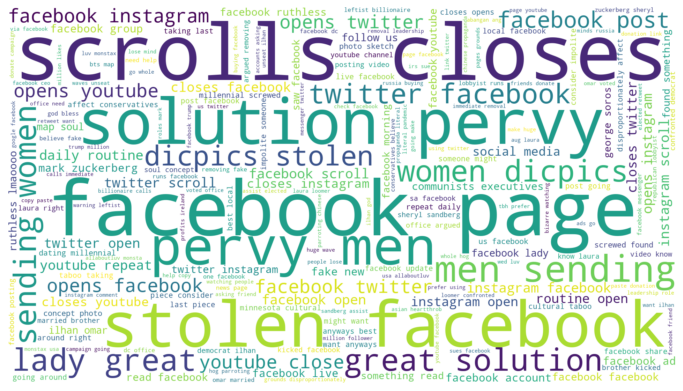

In [27]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_clean_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This wordcloud shows the most used words in tweets for this company. The wordcloud also makes collocations, showing words which are frequently used together.

Some other words can also be seen which had been trending during that time.

### Most used Hashtags

In [28]:
tokenizer = TweetTokenizer()

all_text = []
for text in tweets['text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_text.append(word)
all_text = ' '.join(all_text)

In [29]:
HASHTAG_PATTERN = re.compile(r'#\w*')
all_hashtags = ' '.join(HASHTAG_PATTERN.findall(str(all_text)))

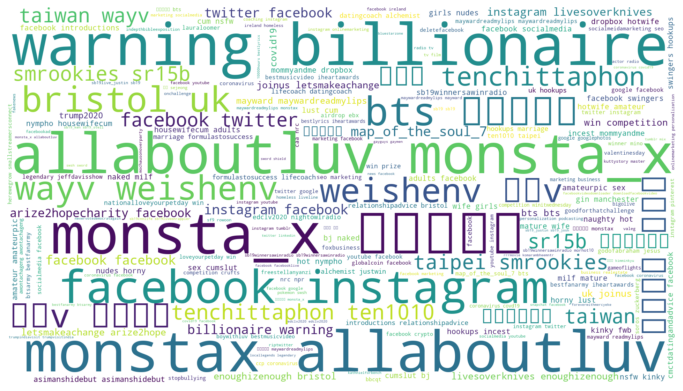

In [30]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_hashtags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [31]:
def get_sentiment(text):
    return TextBlob(text).sentiment

In [32]:
%%time
sentiment = tweets['clean_text'].apply(lambda x: get_sentiment(x))
tweets['polarity'] = sentiment.apply(lambda x: x[0])
tweets['subjectivity'] = sentiment.apply(lambda x: x[1])

CPU times: user 3min 30s, sys: 14.8 s, total: 3min 45s
Wall time: 3min 52s


In [33]:
tweets[['text','polarity','subjectivity']].head()

,text,polarity,subjectivity
0,Visit our Facebook page https://t.co/fwN1JYLHx...,0.208333,0.633333
1,Their free Facebook is why I deleted that App....,0.400000,0.800000
2,Good morning to one &amp; all...by yours truly...,0.150000,0.425000
3,Why dating as a millennial is so screwed up?\r...,0.000000,0.000000
4,@lazmasaba Facebook,0.000000,0.000000


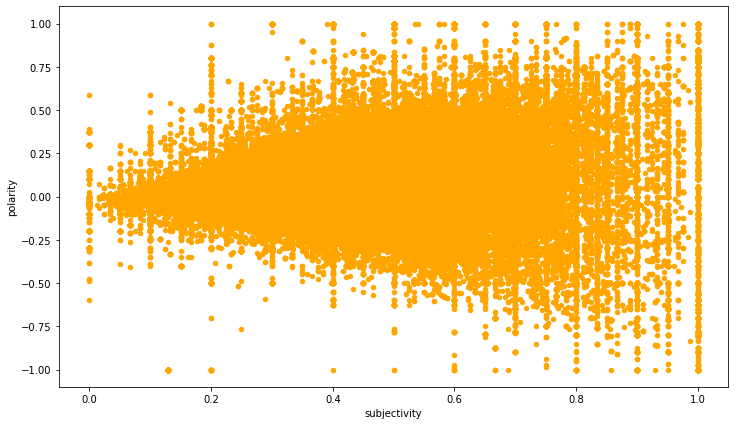

In [34]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE, color='orange')
plt.show()

From the above graph we can see, as the polarity becomes extreme, the subjectivity also increases. That is, more a person is opinionated, more subjective there views are.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6ebddc240>,
      dtype=object)

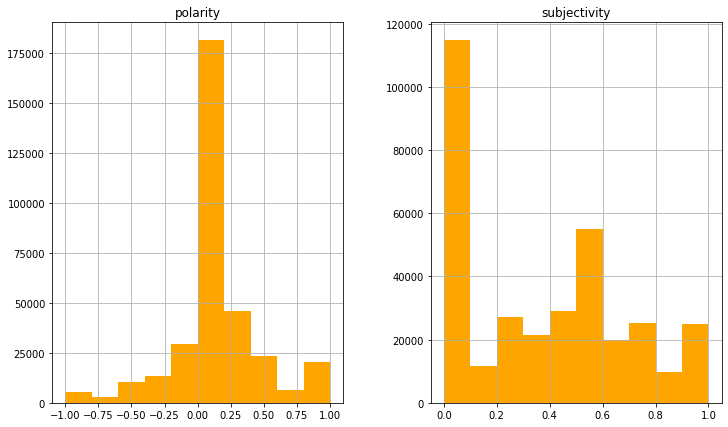

In [35]:
tweets[['polarity','subjectivity']].hist(figsize=FIGURE_SIZE, color='orange')

Histogram for polarity and subjectivity shows that, most tweets have a polarity score of around 0, with a bias towards positive values and subjectivity score many around 0 but more around 0.4 to 0.6. This shows that most tweets have a neutral sentimnt with some being positive and most tweets are subjective, that is, people are more emotionally involved with the brand.

### Sentiment Over Time

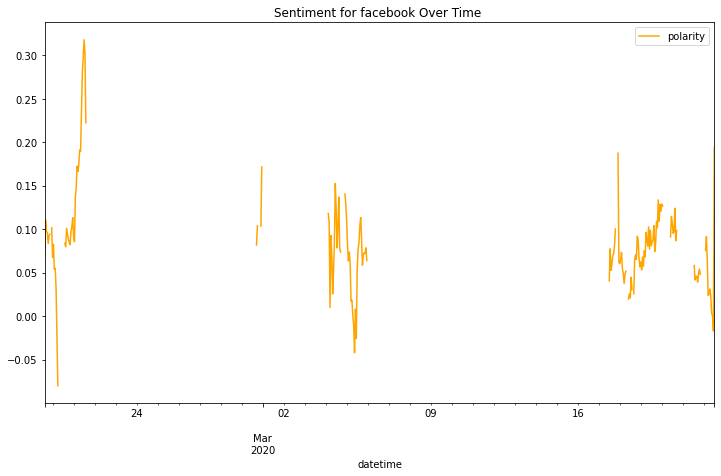

In [36]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H'))\
.mean().plot(figsize=FIGURE_SIZE, color='orange')
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

From the above graph we can see that the sentiment remains mostly positive over the period of 33 days. 

### Top Twitter Clients

In [37]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

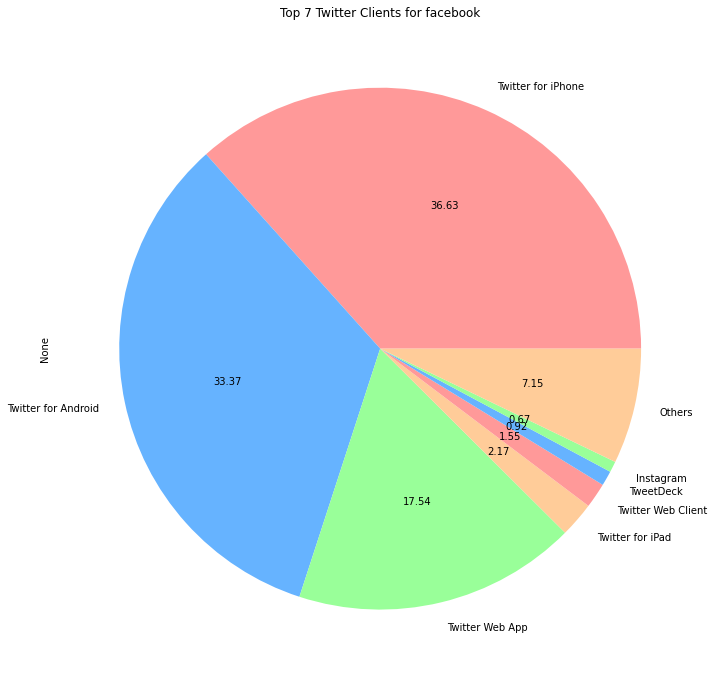

In [38]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others']))\
.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

This chart shows the most prefered twitter clients for people tweeting about this company.

### Average Sentiment of people using particular twitter clients

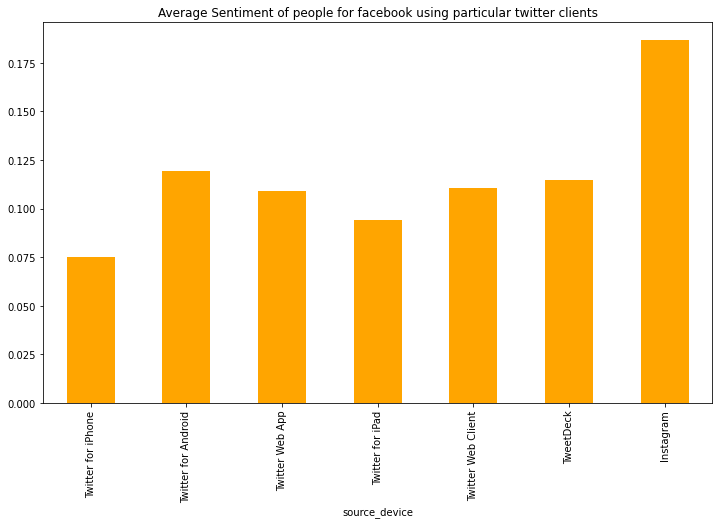

In [39]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:7]\
.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()

From the above chart we can see that many people tweet from there instagram accounts and there opinion is comparitively favorable for the company.

### Most tweeting countries

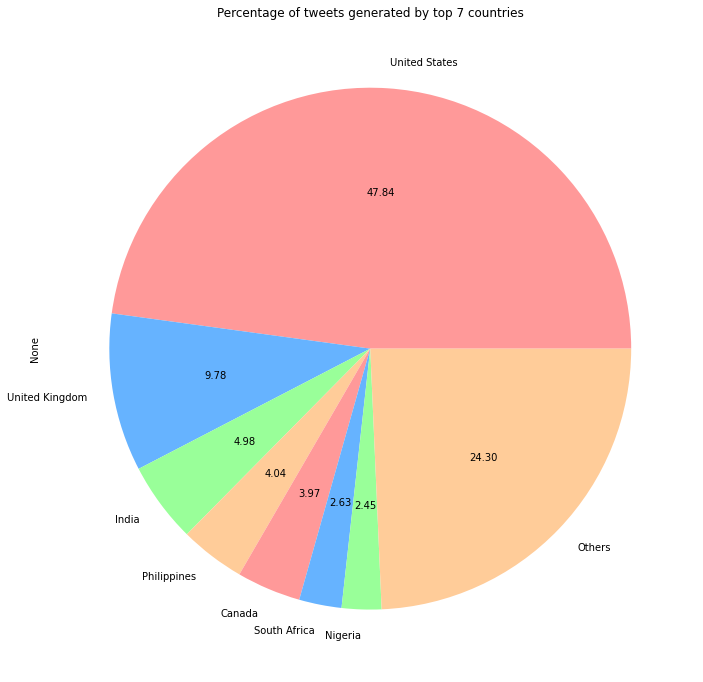

In [40]:
most_tweet_countries = tweets[['country','polarity']].groupby('country').agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[('polarity','size')]
top_7_countries = most_tweet_countries[:7]
top_7_countries.index = top_7_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries = top_7_countries.append(pd.Series(most_tweet_countries[7:].sum(), index=['Others']))
most_tweet_countries.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title('Percentage of tweets generated by top 7 countries')
plt.show()

### Sentiment of people in countries tweeting most

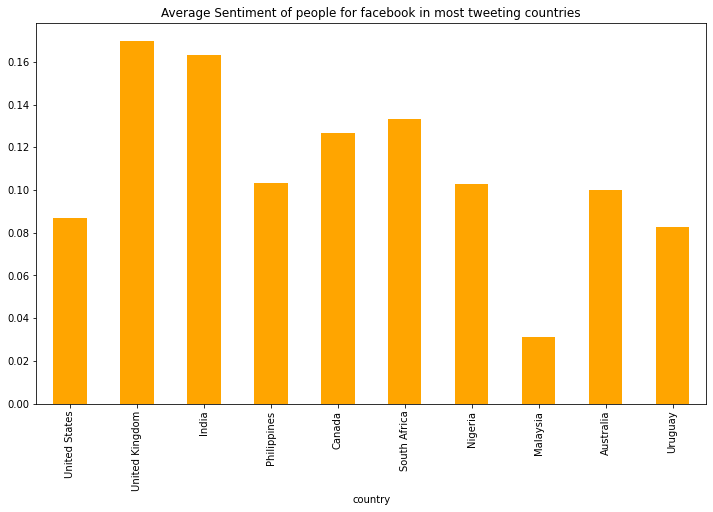

In [41]:
most_tweet_countries = tweets[['country','polarity']].groupby('country')\
.agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[:10]
most_tweet_countries.index = most_tweet_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries[('polarity','mean')].plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} in most tweeting countries')
plt.show()

From the above bar chart, we can see that people in India and United Kingdom people have a higher positive sentiment for facebook. For some reason peoples opinion is not that favorable for facebook in Malaysia.